In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import requests
import os

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

ModuleNotFoundError: No module named 'readligo'

In [2]:
import pycbc
from pycbc.waveform import get_td_waveform
import gwpy
from gwpy.timeseries import TimeSeries
from scipy.io import wavfile

ModuleNotFoundError: No module named 'pycbc'

## Download and Read JSON file with GWTC-1 parameters

In [20]:
# -- Download JSON file
!wget 'https://www.gw-openscience.org/catalog/GWTC-1-confident/filelist/' -O 'filelist.json'

# -- Read json
with open('filelist.json', 'r') as fn:
    jsonstr = fn.read()
    jsonDict = json.loads(jsonstr)

--2019-08-22 15:08:20--  https://www.gw-openscience.org/catalog/GWTC-1-confident/filelist/
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.125.179
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.125.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81998 (80K) [application/json]
Saving to: ‘filelist.json’

filelist.json       100%[===================>]  80.08K  --.-KB/s    in 0.005s  

2019-08-22 15:08:20 (15.2 MB/s) - ‘filelist.json’ saved [81998/81998]



### Generate waveforms, download data, and output WAV files

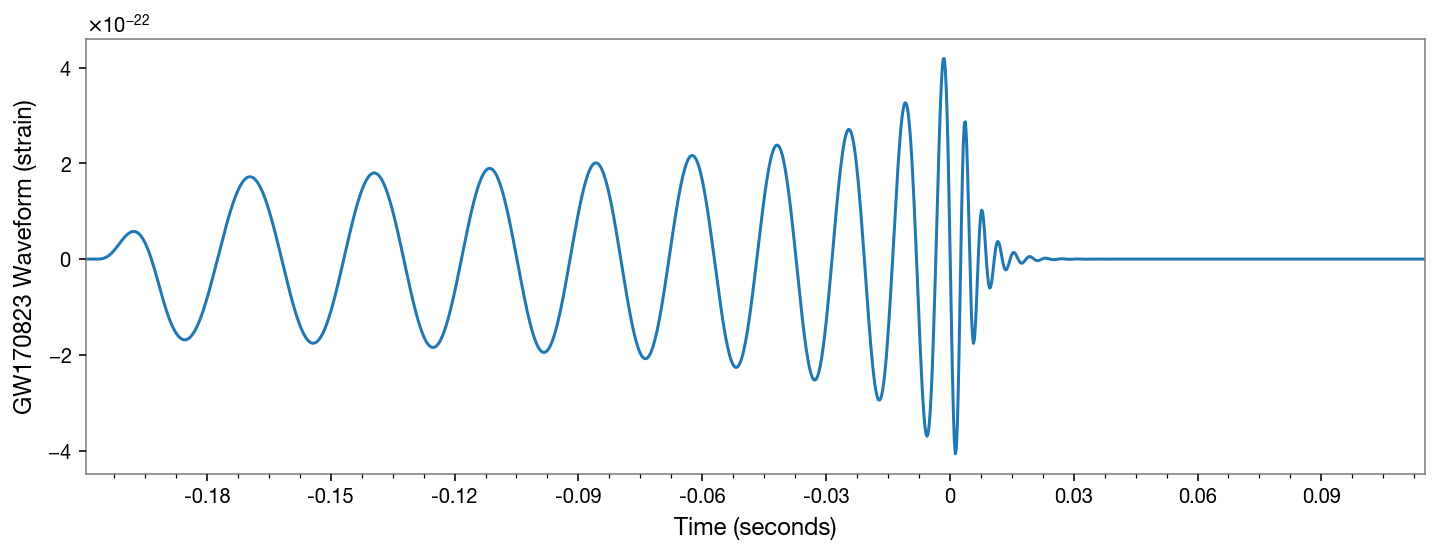

In [21]:
# -- Get a list of file URL's for each event
fs = int(4096)

audiolist = []
for name, infodict in jsonDict['data'].items():

    # -- Generate waveform for each event based on 1-D parameters
    m1 = infodict['mass1']['best']
    m2 = infodict['mass2']['best']
    spin = infodict['chi_eff']['best']
    distance = infodict['distance']['best']
    gps = infodict['tc']['best']
    snr = infodict['snr_gstlal']['best']
    apx = ['SEOBNRv2', 'SpinTaylorT2']
    flow = 30
    
    # -- Set different parameters based on BNS or BBH
    if (m1>5): 
        apx = apx[0]
        bphigh = 600
        start_file = -2
    else: 
        apx = apx[1]
        flow = 70
        bphigh = 1100
        start_file = -7
        
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=spin,
                                 delta_t=1.0/fs,
                                 distance = distance,
                                 f_lower=flow)
     
    start = hp.sample_times[0]
    #hp = pycbc.waveform.utils.td_taper(hp, start=start, end=start+0.2, beta=8, side='left')
    
    # -- Load waveforms into gwpy timeseries
    gwpy_template = TimeSeries(hp)
    gwpy_template.dt = 1.0/fs
    gwpy_template.t0 = hp.sample_times[0]
    
    # -- Taper waveform
    template_taper = gwpy_template.taper()
    
    # -- Plot and save figure
    figfn =  name + '-template' + '.png'
    template_taper.plot()
    plt.grid(False)
    plt.ylabel(name + ' Waveform (strain)')
    plt.xlabel('Time (seconds)')
    plt.savefig(os.path.join('wav',figfn))
    
    # -- Zero pad template waveform
    padding_tuple = ((fs*16-len(template_taper), fs*16))
    template_padded = template_taper.pad(padding_tuple)
    
    bp_waveform = template_padded.bandpass(30, bphigh)
    bp_waveform.times=None
    template_wav = bp_waveform.crop(start_file,2)
    
    # -- Output Template Audio
     # -- Normalize for 16 bit audio
    template_wav = np.int16(template_wav/np.max(np.abs(template_wav)) * 32767 * 0.9)
    audio_fn = name + '-template'+'.wav'
    template_audio_fn = os.path.join('wav', audio_fn)
    wavfile.write(template_audio_fn,int(fs), template_wav.value)


    # -- Create lists of instruments and data files
    ifolist = infodict['files']['OperatingIFOs']
    urllist = []
    for ifo in ifolist.split():
        file_url = infodict['files'][ifo]['32sec']['4KHz']['HDF']
        urllist.append(file_url)        

    # -- Loop over interferometer to download and process data files
    ifoaudiolist = []
    for ifo, url in zip(ifolist.split(),urllist):
        
        if ifo == 'L1' and name == 'GW170817':
            url = 'https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'
        fn = os.path.join('data', os.path.basename(url))
        
        # -- If needed, download strain files
        if False:
            with open(fn,'wb') as strainfile:                 
                straindata = requests.get(url)
                strainfile.write(straindata.content)

        # -- Read strain data
        strain = TimeSeries.read(fn,format='hdf5.losc')
        
        if ifo == 'L1' and name == 'GW170817':
             #-- For cleaned data, grab 32 seconds around trig time
            strain = strain.crop(1187008882-16, 1187008882+16)
             
        # -- Window the data
        strain = strain.taper()
        
        # -- Whiten and bandpass data
        white_data = strain.whiten()
        bp_data = white_data.bandpass(30, bphigh).crop(gps+start_file,gps+2)
        
        # -- window data for gentle on/off
        window = signal.windows.tukey(len(bp_data), alpha=1.0/10)
        bp_data = bp_data*window
        
        # -- Normalize for 16 bit audio
        bp_data = np.int16(bp_data/np.max(np.abs(bp_data)) * 32767 * 0.9)
        
        # -- Make .wav files, seconds
        audio_fn = ifo + '-' + name + '-data'+'.wav'
        audio_fn = os.path.join('wav', audio_fn)
        wavfile.write(audio_fn,int(fs), bp_data.value)
        
        ifoaudiolist.append((ifo,audio_fn))
        
    audiolist.append( (name, template_audio_fn, ifoaudiolist, str(snr), str(m1+m2), figfn ) )
    

### Output README file and HTML table with links to audio files

In [22]:
# -- Make REAMD file to display all the audio

webout = open('README.md', 'w')

webout.write('# Audio Files \n\n')

webout.write("""
# Audio files for confident detections in GWTC-1

These audio files were produced by the code in [audio.ipynb](./audio.ipynb)

All files and code are intended for educational purposes, and are not representative of 
published scientific results.

Template waveforms are based on the median values of 1-D marginalized parameters, and so do not 
match the data to a precision appropriate for scientific analysis.  

For each event, the strain data are real interferometer data that has been whitened and band-passed.
The template waveforms are given without detector noise and after applying a band-pass filter.  The 
template and data audio files have the mergers at approximately the same time, around 2 seconds before
the end of each file.  A glitch was removed from the L1, GW170817 data.

These data represent the very earliest detections of graviational wave signals, and in most cases, 
the signal-to-noise ratio (SNR) is very low.  In many cases, this makes the signals difficult or impossible to 
hear for all but the highest SNR signals.  With good audio equipment, both GW150914 and GW170817 can 
be heard in the data by most people.  Note that, as detector sensitivity improves with time, it is likely 
that signals will be more clearly audible in the data in future runs.  

Higher mass mergers, near a total mass of 50 solar masses, are 'in-band' for only a very short time before
merger, and sound as short 'thuds' lasting around a tenth of a second.  On the other hand, binary neutron 
star mergers are in-band for tens of seconds, and make a distinctive 'chirping' sound.  

All strain data have been downloaded from the Gravitational Wave Open Science Center at gw-openscience.org

## Table of Audio Files
Follow links to audio files in the table below

""")

webout.write('| Name | SNR | Total Mass | Template | Data | \n')
webout.write('|---- | ---- | ---- | ---- | ---- | \n')

for name, template, data, snr, mass, pngfn in audiolist:
    webout.write('| {0} | {1} | {2}'.format(name, snr, mass) + ' M<sub>&#9737;</sub> ')
    webout.write('| [Waveform]({0}) |'.format(template))
    for ifo, fn in data:
        webout.write(' [{0}]({1}) '.format(ifo, fn))
    webout.write('|\n')
webout.close()


In [23]:
# -- Write out HTML table for GWOSC web site

embedstr = """
<audio controls style='width:200px'>
  <source src='/static/audio/gwtc1/{0}' type="audio/wav">
  <a href='/static/audio/gwtc1/{0}'>Audio</a>
</audio>
"""

htmlout = open('audiotable.html', 'w')

htmlout.write('<div class="table-responsive">\n <table class="table">\n')
htmlout.write('<tr>\n')
htmlout.write('<th>Name</th>')
htmlout.write('<th>SNR</th>')
htmlout.write('<th>Total Mass</th>')
htmlout.write('<th>Template</th>')
htmlout.write('<th>Data</th>')
htmlout.write('</tr>\n')
for name, template, data, snr, mass, pngfn in audiolist:
    htmlout.write('<tr><td>{0}</td><td>SNR:<br/>{1}</td><td>Total Mass:<br/>{2} M<sub>&#9737;</sub></td> \n'.format(name, snr, mass) )
    htmlout.write('<td>')
    htmlout.write('<a href="/static/audio/gwtc1/wav/{0}" target="_blank">'.format(pngfn))
    htmlout.write('<img src="/static/audio/gwtc1/wav/{0}" width="200px" /></a><br/>'.format(pngfn) )
    htmlout.write(embedstr.format(template) + '</td><td>' )
    for ifo, fn in data:
        htmlout.write(ifo + '<br/>' + embedstr.format(fn) + '<br/>') 
    htmlout.write('<br/><br/></td></tr>\n')
htmlout.write('</table></div>')
htmlout.close()